In [26]:
import glob
import os
import lxml.etree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Extracting Structured Data from ParlaMint-PT (TEI XML)

In this step, we parse the ParlaMint-PT TEI-encoded parliamentary debates and transform them into a structured format suitable for analysis.  
The result is stored in a pandas DataFrame where each row corresponds to a single utterance (<u> element) in the corpus.  

In [4]:
# Path to your TEI files
tei_path = r"C:\Users\Joana & Sofia\Documents\Ju\NOVA SBE\Thesis\ParlaMint-PT.TEI"

# Load speaker metadata if listPerson.xml exists
speakers_dict = {}
persons_file = os.path.join(tei_path, "ParlaMint-PT-listPerson.xml")
if os.path.exists(persons_file):
    tree = ET.parse(persons_file)
    root = tree.getroot()
    for person in root.findall(".//{*}person"):
        pid = person.attrib.get("{http://www.w3.org/XML/1998/namespace}id")

        # Full name, clean whitespace and join all text parts
        name_el = person.find(".//{*}persName")
        name = " ".join(name_el.itertext()).replace("\n", " ").split() if name_el is not None else pid
        name = " ".join(name)

        # Gender
        sex_el = person.find(".//{*}sex")
        gender = sex_el.attrib.get("value") if sex_el is not None else "Unknown"

        # Party
        affil_el = person.find(".//{*}affiliation")
        party_id = affil_el.attrib.get("ref", "Unknown") if affil_el is not None else "Unknown"
        party_name_el = affil_el.find(".//{*}orgName") if affil_el is not None else None
        party_name = party_name_el.text.strip() if party_name_el is not None else party_id

        speakers_dict[pid] = {
            "name": name,
            "gender": gender,
            "party_id": party_id,
            "party_name": party_name
        }

# Find all session XML files
files = glob.glob(os.path.join(tei_path, "20*/**/*.xml"), recursive=True)
print(f"Found {len(files)} XML files.")

data = []

for f in files:
    if "Schema" in f:
        continue  # Skip schema files

    try:
        tree = ET.parse(f)
        root = tree.getroot()

        # Session metadata
        session_id = root.attrib.get("{http://www.w3.org/XML/1998/namespace}id", os.path.basename(f))
        session_title_el = root.find(".//{*}title")
        session_title = session_title_el.text.strip() if session_title_el is not None and session_title_el.text else "Unknown"

        # Extract year from session_id (ParlaMint-PT_YYYY-MM-DD)
        try:
            year = session_id.split("_")[1].split("-")[0]
        except:
            year = "Unknown"

        # Date: fallback to <date> if available
        date_el = root.find(".//{*}date")
        if date_el is not None and date_el.attrib.get("when"):
            session_date = date_el.attrib.get("when")
        else:
            # Use session_id date if <date> is missing
            session_date = "_".join(session_id.split("_")[1:])

        # Utterances
        for u in root.findall(".//{*}u"):
            speech_id = u.attrib.get("{http://www.w3.org/XML/1998/namespace}id")

            speaker_id = u.attrib.get("who")
            speaker_id = speaker_id.lstrip("#") if speaker_id else "Unknown"

            speech_type = u.attrib.get("ana", "Unknown")
            lang = u.attrib.get("{http://www.w3.org/XML/1998/namespace}lang", "pt")

            # Get speaker info
            speaker_info = speakers_dict.get(
                speaker_id,
                {"name": speaker_id, "gender": "Unknown", "party_id": "Unknown", "party_name": "Unknown"}
            )

            # Combine <seg> text
            text = " ".join(seg.text.strip() for seg in u.findall(".//{*}seg") if seg.text)
            word_count = len(text.split())

            data.append([
                speech_id, session_id, session_title, session_date, year,
                speaker_id, speaker_info["name"], speaker_info["party_id"], speaker_info["party_name"],
                speaker_info["gender"], speech_type, lang,
                word_count, text
            ])

    except Exception as e:
        print(f"⚠️ Error parsing {f}: {e}")

# Create DataFrame
df = pd.DataFrame(data, columns=[
    "speech_id", "session_id", "session_title", "date", "year",
    "speaker_id", "speaker_name", "party_id", "party_name",
    "gender", "speech_type", "language",
    "word_count", "text"
])

# Preview
print(df.head(10))

# Optionally save to CSV
# df.to_csv("ParlaMint_PT_corpus_all_years.csv", index=False)


Found 901 XML files.
                     speech_id               session_id  \
0   ParlaMint-PT_2015-01-07.u1  ParlaMint-PT_2015-01-07   
1   ParlaMint-PT_2015-01-07.u2  ParlaMint-PT_2015-01-07   
2   ParlaMint-PT_2015-01-07.u3  ParlaMint-PT_2015-01-07   
3   ParlaMint-PT_2015-01-07.u4  ParlaMint-PT_2015-01-07   
4   ParlaMint-PT_2015-01-07.u5  ParlaMint-PT_2015-01-07   
5   ParlaMint-PT_2015-01-07.u6  ParlaMint-PT_2015-01-07   
6   ParlaMint-PT_2015-01-07.u7  ParlaMint-PT_2015-01-07   
7   ParlaMint-PT_2015-01-07.u8  ParlaMint-PT_2015-01-07   
8   ParlaMint-PT_2015-01-07.u9  ParlaMint-PT_2015-01-07   
9  ParlaMint-PT_2015-01-07.u10  ParlaMint-PT_2015-01-07   

                                       session_title        date  year  \
0  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2015   
1  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2015   
2  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2015   
3  Corpus parlamentar português P

In [5]:
# Example: print the first row completely
print(df.iloc[0].to_string())

speech_id                               ParlaMint-PT_2015-01-07.u1
session_id                                 ParlaMint-PT_2015-01-07
session_title    Corpus parlamentar português ParlaMint-PT, Sér...
date                                                    2025-06-20
year                                                          2015
speaker_id                           MariadaAssunçãoAndradeEsteves
speaker_name                     Maria da Assunção Andrade Esteves
party_id                                                      #PSD
party_name                                                    #PSD
gender                                                           F
speech_type                                     #chair topic:other
language                                                        pt
word_count                                                      82
text             Srs. Deputados, Srs. Jornalistas, Srs. Funcion...


## Overview of the Dataset

C:\Temp\ipykernel_27388\204550213.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=speech_counts.index, y=speech_counts.values, palette="viridis")


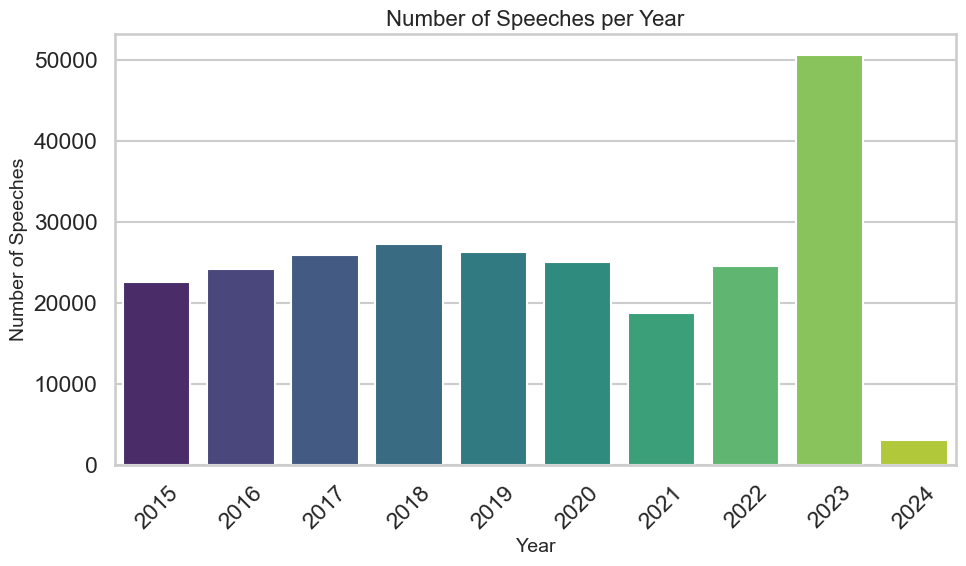

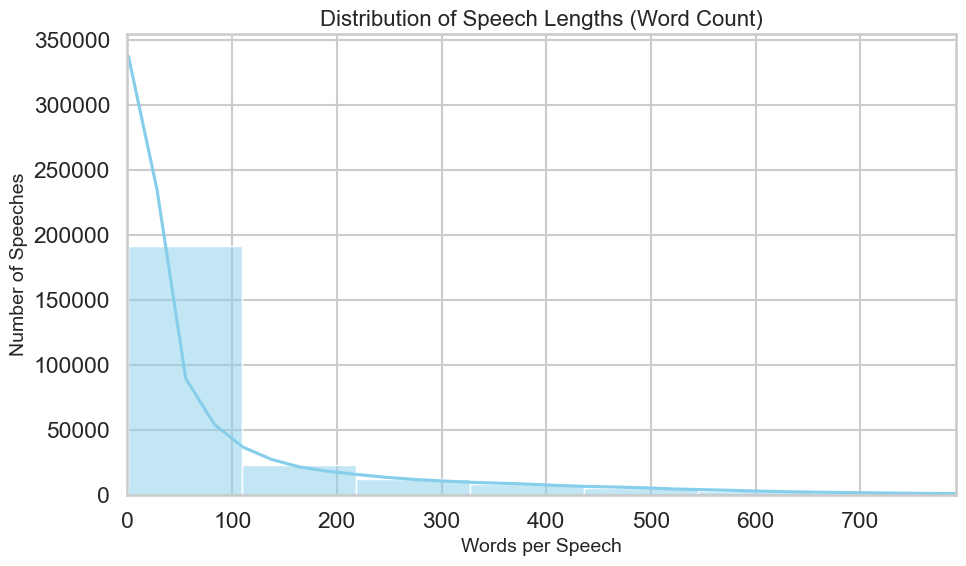

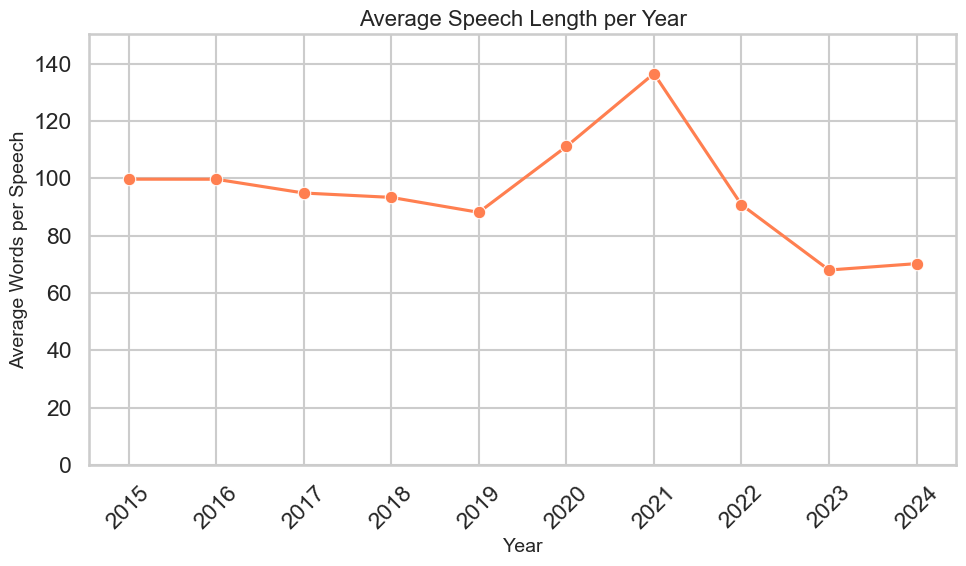

In [7]:


# Set Seaborn style
sns.set(style="whitegrid", context="talk", palette="muted")

# ----- Number of speeches per year -----
plt.figure(figsize=(10,6))
speech_counts = df.groupby('year')['speech_id'].count().sort_index()
sns.barplot(x=speech_counts.index, y=speech_counts.values, palette="viridis")
plt.title("Number of Speeches per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Speeches", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ----- Distribution of speech lengths -----
plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Speech Lengths (Word Count)", fontsize=16)
plt.xlabel("Words per Speech", fontsize=14)
plt.ylabel("Number of Speeches", fontsize=14)
plt.xlim(0, df['word_count'].quantile(0.99))  # limit x-axis to 99th percentile to avoid long tails
plt.tight_layout()
plt.show()

# ----- Compute average speech length per year -----

avg_length = df.groupby('year')['word_count'].mean().sort_index()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(x=avg_length.index, y=avg_length.values, marker="o", color="coral")
plt.title("Average Speech Length per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Words per Speech", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, avg_length.max()*1.1)  # Add a little space above max
plt.tight_layout()
plt.show()


The first graph, number of speeches per year shows the speech distributuion from 2015 until 13th of March 2024. In the histogram we can see that in 2023 is substatially higher than in all other years. In 2024 we only have the speeches for the first two and half months, that is why the count of speeches is lower.

The distribution of speech lenght is positively skewed.

The average speech lenght per year exhibits an increase in 2020 and 2021 and a decrease since 2021 until 2024

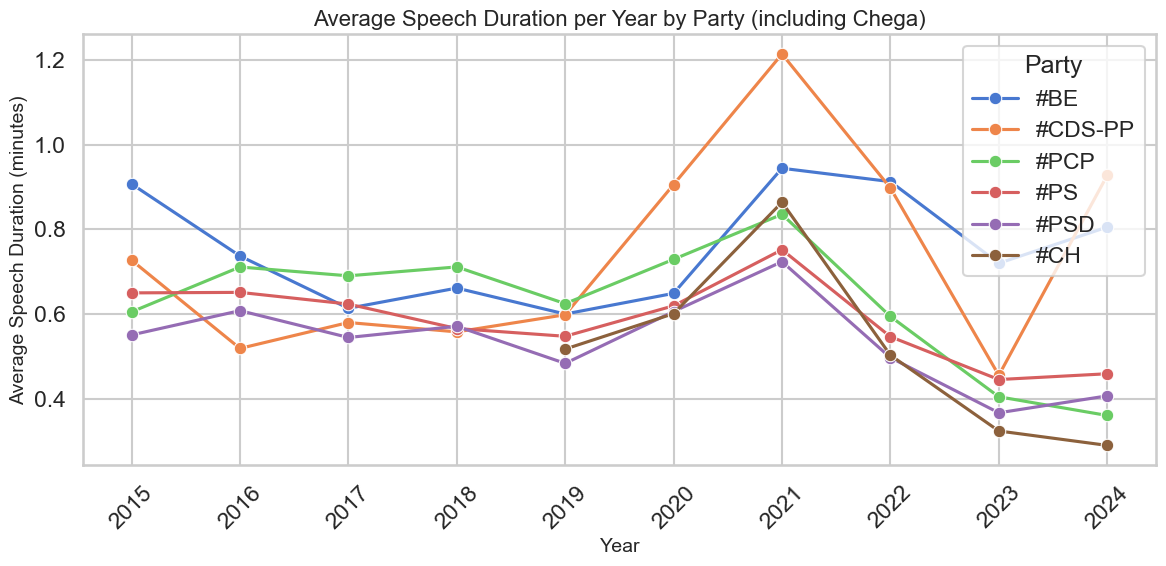

In [12]:
# Make sure we have minutes
df['minutes'] = df['word_count'] / 150

# Average speech duration per year & party
avg_minutes_by_party_year = (
    df.groupby(['year','party_name'])['minutes']
      .mean()
      .reset_index()
)

# Pick top N parties + Chega
top_parties = df['party_name'].value_counts().head(5).index.tolist()
if "#CH" not in top_parties:
    top_parties.append("#CH")

plot_data = avg_minutes_by_party_year[avg_minutes_by_party_year['party_name'].isin(top_parties)]

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=plot_data,
    x='year', y='minutes',
    hue='party_name', marker="o"
)
plt.title("Average Speech Duration per Year by Party (including Chega)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Speech Duration (minutes)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Party")
plt.tight_layout()
plt.show()


In [8]:
print(df.shape)   # number of rows, columns
print(df.info())  # column types, missing values
print(df['party_name'].value_counts().head(10))  # most frequent parties
print(df['gender'].value_counts())


(248577, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248577 entries, 0 to 248576
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   speech_id      248577 non-null  object
 1   session_id     248577 non-null  object
 2   session_title  248577 non-null  object
 3   date           248577 non-null  object
 4   year           248577 non-null  object
 5   speaker_id     248577 non-null  object
 6   speaker_name   248577 non-null  object
 7   party_id       248577 non-null  object
 8   party_name     248577 non-null  object
 9   gender         248577 non-null  object
 10  speech_type    248577 non-null  object
 11  language       248577 non-null  object
 12  word_count     248577 non-null  int64 
 13  text           248577 non-null  object
dtypes: int64(1), object(13)
memory usage: 26.6+ MB
None
party_name
#PS        87370
#PSD       54551
#PCP       29051
#BE        25945
#CDS-PP    22195
#CH        12670
#I

C:\Temp\ipykernel_27388\518415630.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=party_counts.index, y=party_counts.values, palette="mako")


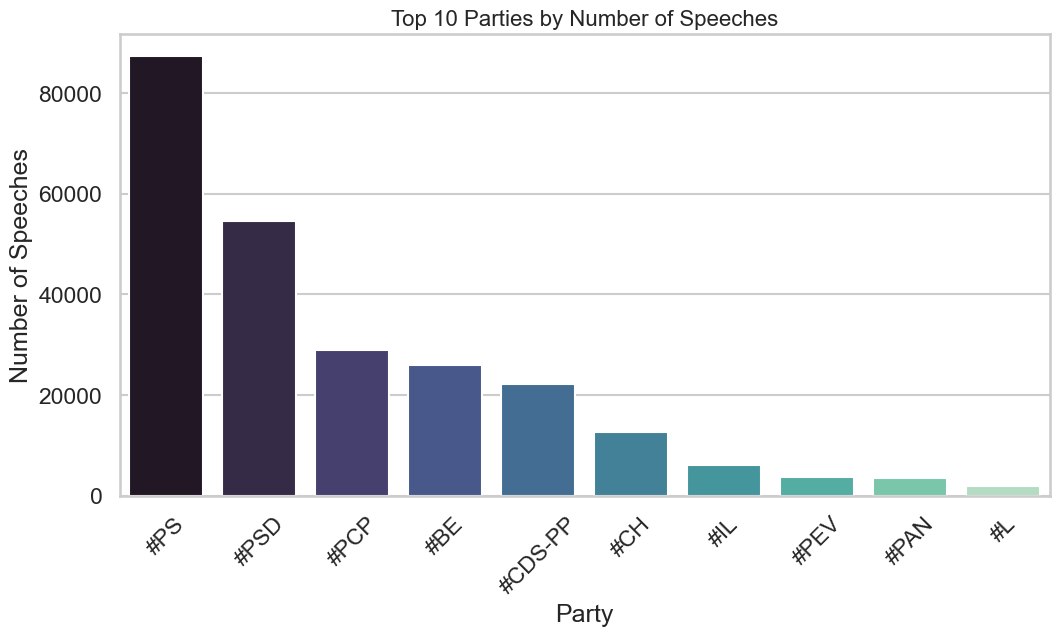

C:\Temp\ipykernel_27388\518415630.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=party_minutes.index, y=party_minutes.values, palette="mako")


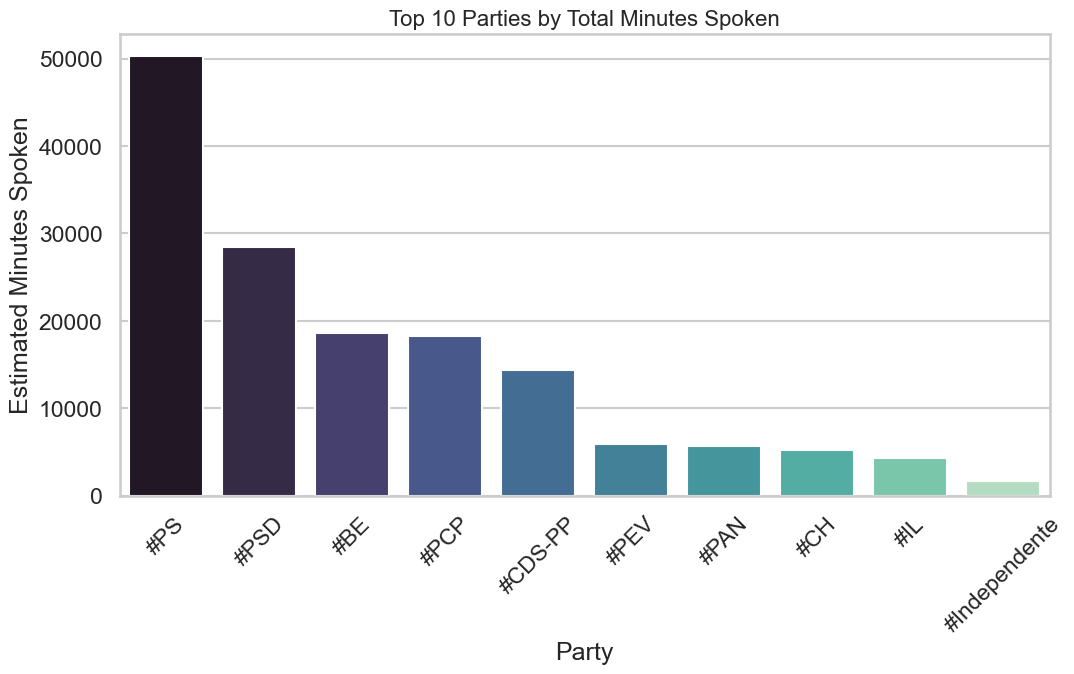

In [10]:
plt.figure(figsize=(12,6))
party_counts = df['party_name'].value_counts().head(10)  # top 10 parties
sns.barplot(x=party_counts.index, y=party_counts.values, palette="mako")
plt.title("Top 10 Parties by Number of Speeches", fontsize=16)
plt.ylabel("Number of Speeches")
plt.xlabel("Party")
plt.xticks(rotation=45)
plt.show()

# Add column for estimated minutes
df['minutes'] = df['word_count'] / 150

# Sum minutes by party
party_minutes = df.groupby('party_name')['minutes'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=party_minutes.index, y=party_minutes.values, palette="mako")
plt.title("Top 10 Parties by Total Minutes Spoken", fontsize=16)
plt.ylabel("Estimated Minutes Spoken")
plt.xlabel("Party")
plt.xticks(rotation=45)
plt.show()


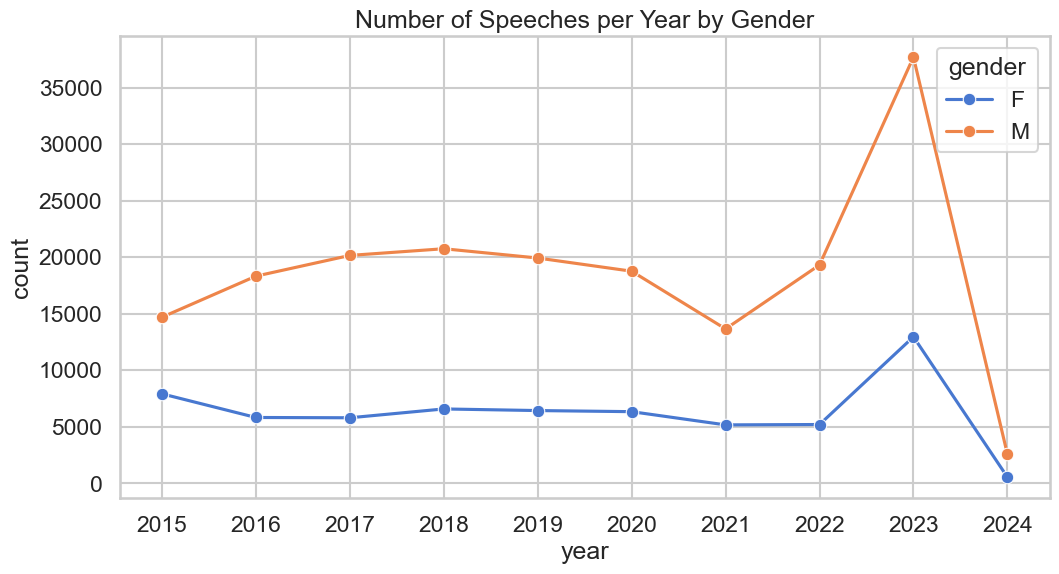

In [13]:
gender_by_year = df.groupby(['year','gender']).size().reset_index(name='count')
plt.figure(figsize=(12,6))
sns.lineplot(data=gender_by_year, x='year', y='count', hue='gender', marker="o")
plt.title("Number of Speeches per Year by Gender")
plt.show()


C:\Temp\ipykernel_27388\2767157944.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_speakers.values, y=top_speakers.index, palette="crest")


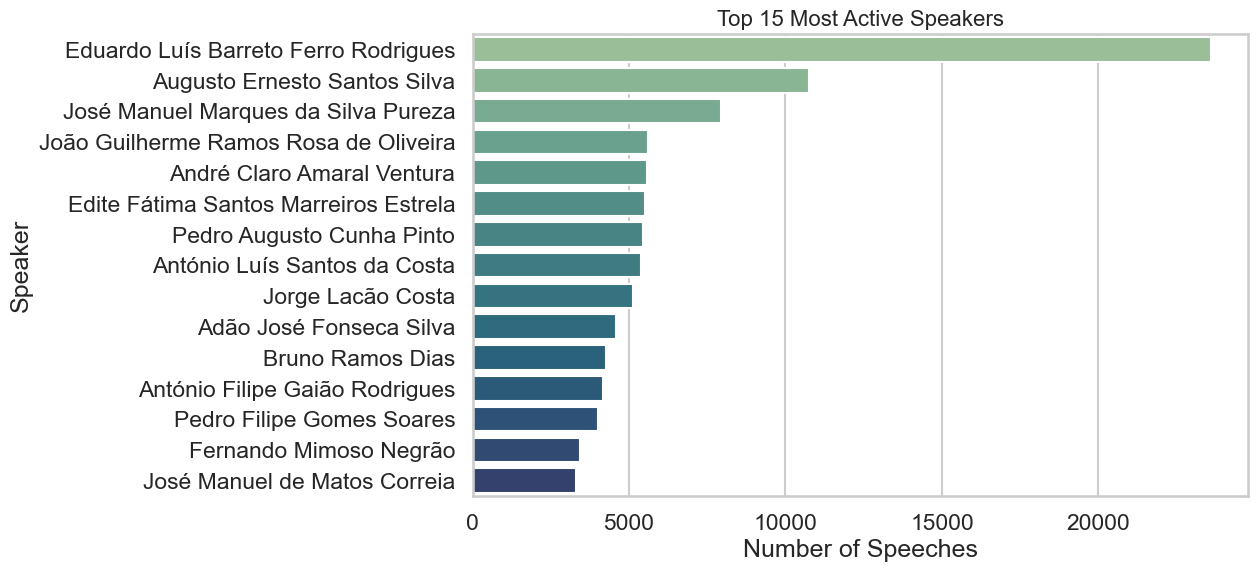

In [14]:
top_speakers = df['speaker_name'].value_counts().head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top_speakers.values, y=top_speakers.index, palette="crest")
plt.title("Top 15 Most Active Speakers", fontsize=16)
plt.xlabel("Number of Speeches")
plt.ylabel("Speaker")
plt.show()


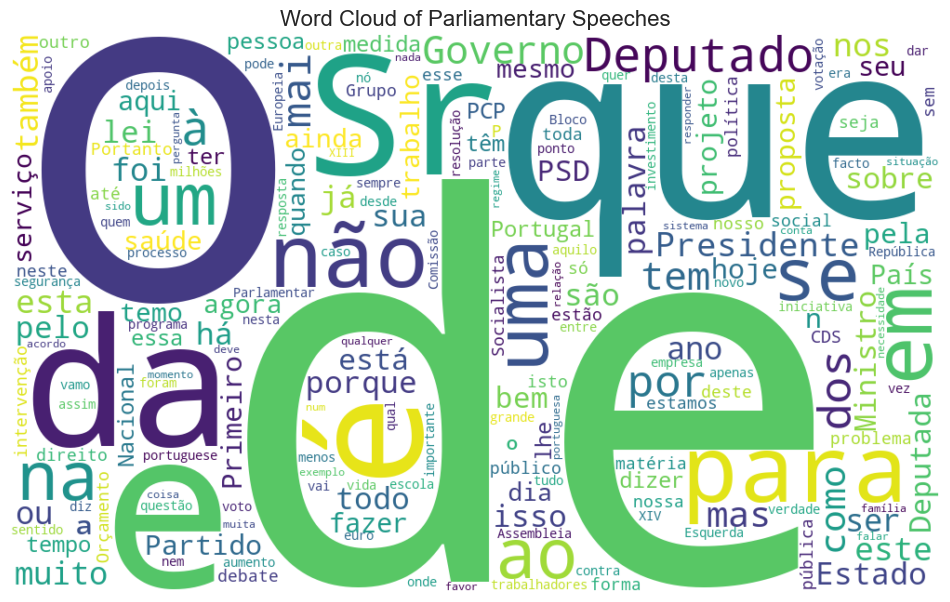

In [16]:
from wordcloud import WordCloud

text_all = " ".join(df['text'].dropna().sample(5000, random_state=42))  # sample to save memory
wc = WordCloud(width=1000, height=600, background_color="white", collocations=False).generate(text_all)

plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Parliamentary Speeches", fontsize=16)
plt.show()


## Chega Deepdive


In [20]:
sns.set(style="whitegrid", context="talk")

# Minutes ≈ words / 150 (speech rate)
if 'minutes' not in df.columns:
    df['minutes'] = df['word_count'] / 150.0

# Clean year for sorting
df['year_num'] = pd.to_numeric(df['year'], errors='coerce')

# Robust Chega filter (party_id or party_name can be '#CH' / 'CH' / 'Chega')
is_ch = (
    df['party_id'].str.upper().str.contains('CH', na=False) |
    df['party_name'].str.upper().str.contains('CHEGA|^#CH$', na=False)
)
ch = df[is_ch].copy()

print(f"Total speeches: {len(df):,} | Chega speeches: {len(ch):,}")

Total speeches: 248,577 | Chega speeches: 12,670


### 1: How big is Chega’s presence? (counts, minutes, shares)

 year_num  total_speeches  total_minutes  ch_speeches  ch_minutes  share_speeches_%  share_minutes_%  ch_avg_minutes
     2015           22601       15022.27          0.0        0.00              0.00             0.00            0.00
     2016           24142       16043.19          0.0        0.00              0.00             0.00            0.00
     2017           25949       16412.27          0.0        0.00              0.00             0.00            0.00
     2018           27322       17002.25          0.0        0.00              0.00             0.00            0.00
     2019           26358       15485.95        135.0       69.87              0.51             0.45            0.52
     2020           25094       18587.25        921.0      553.67              3.67             2.98            0.60
     2021           18821       17132.30        526.0      454.51              2.79             2.65            0.86
     2022           24512       14835.35       3157.0     1588.5

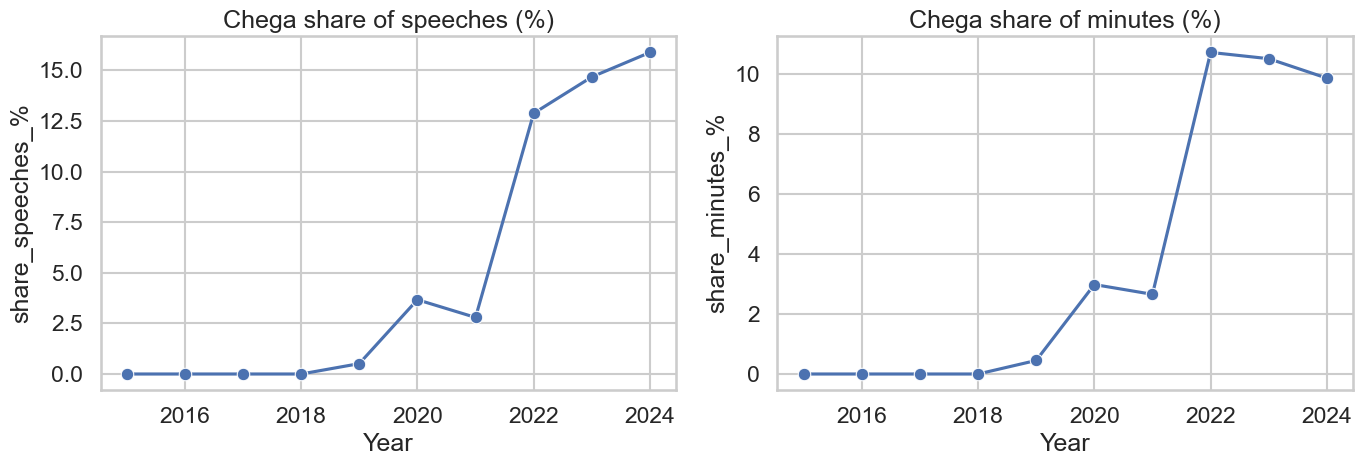

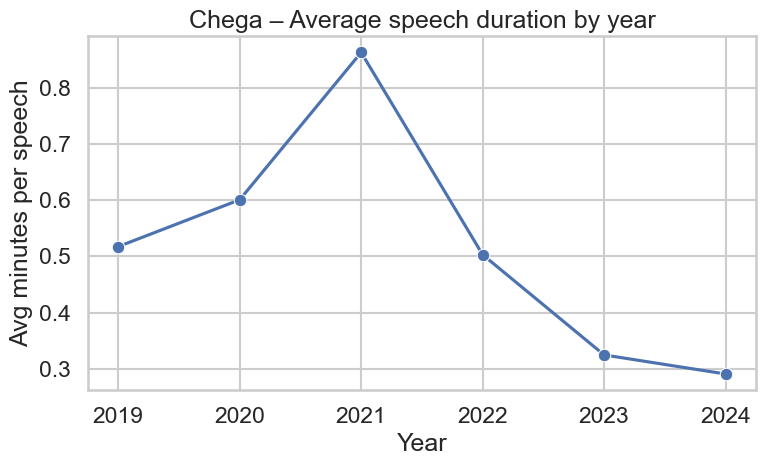

In [24]:
# Per-year totals
totals = (df.dropna(subset=['year_num'])
            .groupby('year_num')
            .agg(total_speeches=('speech_id','count'),
                 total_minutes=('minutes','sum'))
            .reset_index())

ch_year = (ch.dropna(subset=['year_num'])
             .groupby('year_num')
             .agg(ch_speeches=('speech_id','count'),
                  ch_minutes=('minutes','sum'),
                  ch_avg_minutes=('minutes','mean'))
             .reset_index())

mix = totals.merge(ch_year, on='year_num', how='left').fillna(0)
mix['share_speeches_%'] = 100*mix['ch_speeches']/mix['total_speeches']
mix['share_minutes_%']  = 100*mix['ch_minutes']/mix['total_minutes']

display_cols = ['year_num','total_speeches','total_minutes','ch_speeches','ch_minutes',
                'share_speeches_%','share_minutes_%','ch_avg_minutes']
print(mix[display_cols].round(2).to_string(index=False))

# Share of minutes & speeches over time
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.lineplot(data=mix, x='year_num', y='share_speeches_%', marker='o', ax=ax[0])
ax[0].set_title("Chega share of speeches (%)"); ax[0].set_xlabel("Year")
sns.lineplot(data=mix, x='year_num', y='share_minutes_%', marker='o', ax=ax[1])
ax[1].set_title("Chega share of minutes (%)"); ax[1].set_xlabel("Year")
plt.tight_layout(); plt.show()

# Average speech duration (minutes) for Chega over years
plt.figure(figsize=(8,5))
sns.lineplot(data=ch_year, x='year_num', y='ch_avg_minutes', marker='o')
plt.title("Chega – Average speech duration by year")
plt.xlabel("Year"); plt.ylabel("Avg minutes per speech"); plt.tight_layout(); plt.show()


### 2: Who speaks for Chega? (top speakers, totals & averages)


Top 15 Chega speakers by total minutes:
                                               speeches  minutes  avg_minutes
speaker_name                                                                 
André Claro Amaral Ventura                         5561  2745.53         0.49
Pedro Saraiva Gonçalves dos Santos Frazão          2154   460.09         0.21
Bruno Miguel de Oliveira Nunes                     1328   434.33         0.33
Rita Maria Cid Matias                              1090   352.99         0.32
António Filipe Dias Melo Peixoto                   1166   296.72         0.25
Rui Pedro da Silva Afonso                           278   224.05         0.81
Gabriel Sérgio Mithá Ribeiro                        311   169.64         0.55
Rui Paulo Duque Sousa                               227   166.81         0.73
Jorge Manuel de Valsassina Galveias Rodrigues       276   166.41         0.60
Diogo Velez Mouta Pacheco de Amorim                 184   106.20         0.58
Pedro Manuel de Andrade

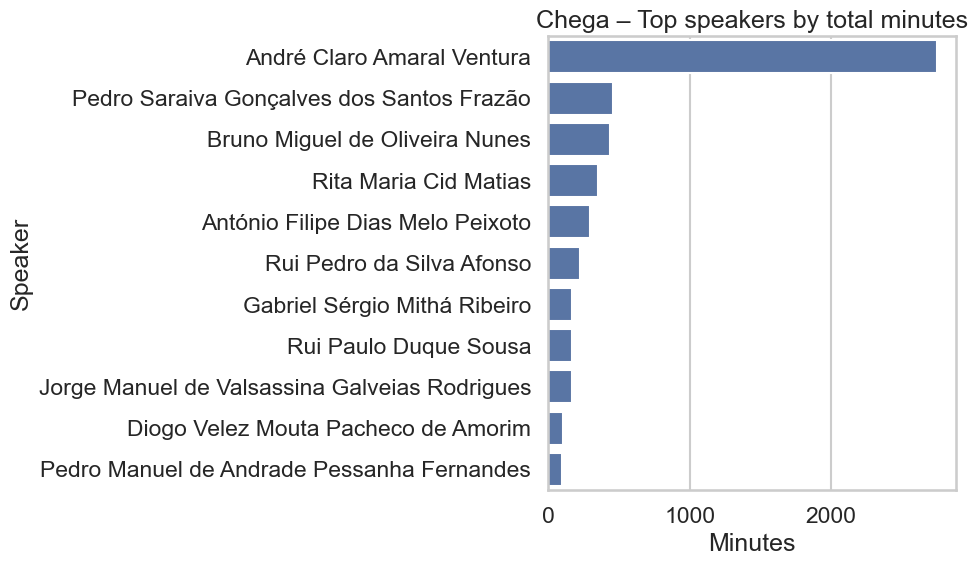


Longest 10 Chega speeches:
             session_id                    speech_id               speaker_name  word_count   minutes       date
ParlaMint-PT_2021-06-23  ParlaMint-PT_2021-06-23.u55 André Claro Amaral Ventura        2305 15.366667 2025-06-20
ParlaMint-PT_2022-09-23  ParlaMint-PT_2022-09-23.u12 André Claro Amaral Ventura        1734 11.560000 2025-06-20
ParlaMint-PT_2021-06-23  ParlaMint-PT_2021-06-23.u67 André Claro Amaral Ventura        1485  9.900000 2025-06-20
ParlaMint-PT_2022-05-27 ParlaMint-PT_2022-05-27.u107 André Claro Amaral Ventura        1472  9.813333 2025-06-20
ParlaMint-PT_2021-06-23   ParlaMint-PT_2021-06-23.u4 André Claro Amaral Ventura        1445  9.633333 2025-06-20
ParlaMint-PT_2022-04-25  ParlaMint-PT_2022-04-25.u12 André Claro Amaral Ventura        1398  9.320000 2025-06-20
ParlaMint-PT_2022-10-27 ParlaMint-PT_2022-10-27.u524 André Claro Amaral Ventura        1391  9.273333 2025-06-20
ParlaMint-PT_2022-01-06  ParlaMint-PT_2022-01-06.u32 André Claro Ama

In [28]:
# Totals by speaker
ch_speakers = (ch.groupby('speaker_name')
                 .agg(speeches=('speech_id','count'),
                      minutes=('minutes','sum'),
                      avg_minutes=('minutes','mean'))
                 .sort_values('minutes', ascending=False))

print("\nTop 15 Chega speakers by total minutes:")
print(ch_speakers.head(15).round(2).to_string())

# Plot top 12 by total minutes
top_spk = ch_speakers.head(12).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=top_spk, y='speaker_name', x='minutes')
plt.title("Chega – Top speakers by total minutes"); plt.xlabel("Minutes"); plt.ylabel("Speaker")
plt.tight_layout(); plt.show()

# Longest single speeches (by words/minutes)
longest = ch.sort_values('word_count', ascending=False)[
    ['session_id','speech_id','speaker_name','word_count','minutes','date']
].head(10)
print("\nLongest 10 Chega speeches:")
print(longest.to_string(index=False))



Chega speakers normalized by ACTIVE years (minutes/active-year):
                                               active_years  minutes  minutes_per_active_year  speeches  speeches_per_active_year
speaker_name                                                                                                                     
André Claro Amaral Ventura                                6  2745.53                   457.59      5561                    926.83
Pedro Saraiva Gonçalves dos Santos Frazão                 3   460.09                   153.36      2154                    718.00
Bruno Miguel de Oliveira Nunes                            3   434.33                   144.78      1328                    442.67
Rita Maria Cid Matias                                     3   352.99                   117.66      1090                    363.33
António Filipe Dias Melo Peixoto                          3   296.72                    98.91      1166                    388.67
Rui Pedro da Silva Afons

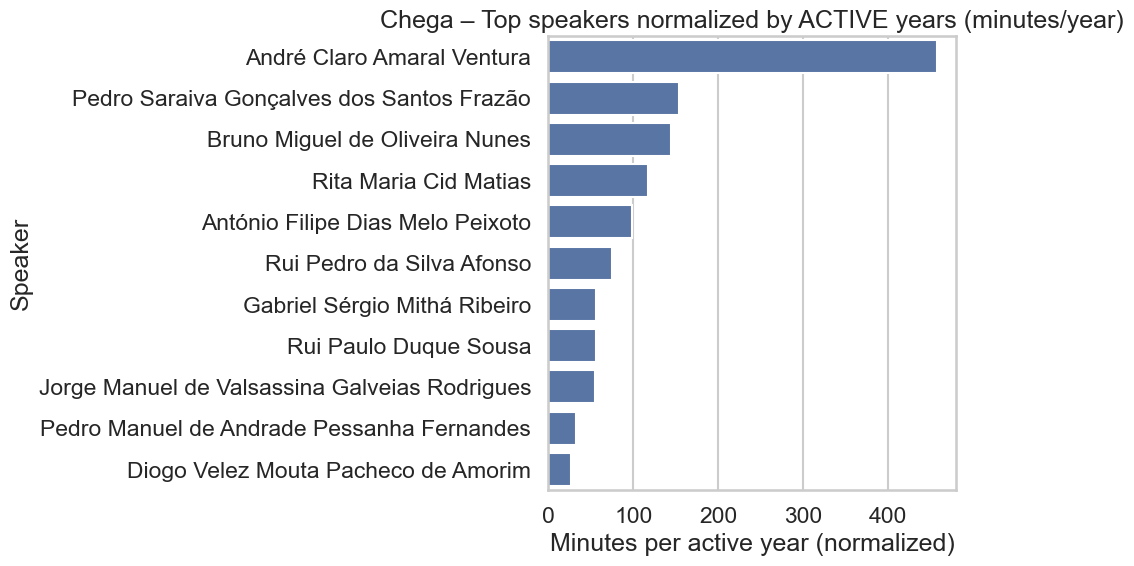

In [30]:
ch_totals = (
    ch.groupby('speaker_name', dropna=False)
      .agg(minutes=('minutes','sum'),
           speeches=('speech_id','count'))
)

active_years = (
    df[df['year_num'].notna()]
      .groupby('speaker_name')['year_num']
      .nunique()
      .rename('active_years')
)

stats_active = (
    ch_totals.join(active_years, how='left')
             .assign(active_years=lambda d: d['active_years'].fillna(1))
             .assign(
                 minutes_per_active_year=lambda d: d['minutes'] / d['active_years'],
                 speeches_per_active_year=lambda d: d['speeches'] / d['active_years']
             )
             .sort_values('minutes_per_active_year', ascending=False)
)

print("\nChega speakers normalized by ACTIVE years (minutes/active-year):")
print(
    stats_active[['active_years','minutes','minutes_per_active_year','speeches','speeches_per_active_year']]
    .head(15).round(2).to_string()
)

# Plot
top_active = stats_active.head(12).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=top_active, y='speaker_name', x='minutes_per_active_year')
plt.title("Chega – Top speakers normalized by ACTIVE years (minutes/year)")
plt.xlabel("Minutes per active year (normalized)")
plt.ylabel("Speaker")
plt.tight_layout()
plt.show()

### 4: What does Chega talk about? (topics from speech_type)


Top Chega topics (by number of speeches):
topic
other    6158
macro     866
mixed     802
healt     694
gover     586
civil     518
lawcr     478
educa     419
inter     303
housi     265
labor     239
welfa     218
immig     199
argic     172
trans     172


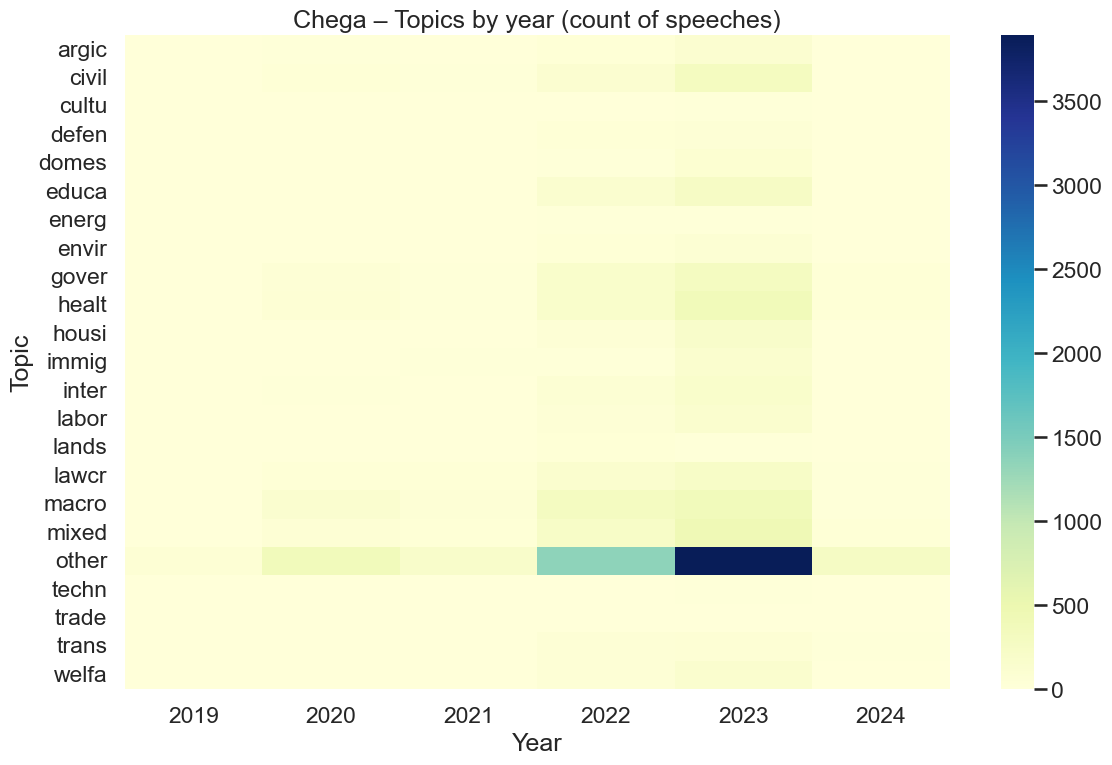

In [32]:
import re

def parse_speech_type(s):
    mode, topic = 'Unknown','Unknown'
    if isinstance(s, str):
        if '#chair' in s: mode = 'chair'
        elif '#regular' in s: mode = 'regular'
        m = re.search(r'topic:([A-Za-z\-]+)', s)
        if m: topic = m.group(1)
    return pd.Series({'mode':mode, 'topic':topic})

extra = ch['speech_type'].apply(parse_speech_type)
ch = ch.join(extra)

# Top topics overall
top_topics = ch['topic'].value_counts().head(15)
print("\nTop Chega topics (by number of speeches):")
print(top_topics.to_string())

# Topics by year (heatmap)
topic_year = (ch.dropna(subset=['year_num'])
                .groupby(['year_num','topic']).size()
                .reset_index(name='count'))
pivot = topic_year.pivot(index='topic', columns='year_num', values='count').fillna(0)
plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title("Chega – Topics by year (count of speeches)")
plt.xlabel("Year"); plt.ylabel("Topic"); plt.tight_layout(); plt.show()
